# Figure 6B. Plot rollout

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations
from typing import Any
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from collab_env.data.file_utils import expand_path, get_project_root

In [3]:
from collab_env.gnn.gnn import plot_log_loss, train_rules_gnn, load_model, save_model, debug_result2prediction
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.sim.boids_gnn_temp.animal_simulation import visualize_graph_2sets, static_visualize_2sets

from collab_env.gnn.utility import dataset2testloader
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from itertools import product

In [4]:
smoke_test = "CI" in os.environ

save_flag = True if not smoke_test else False

In [5]:
data_names = ['boid_food_basic','boid_food_independent', 'boid_food_strong'] #'runpod/boid_single_species_basic']
#data_names = ['boid_food_strong'] #'runpod/boid_single_species_basic']
data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'

### 1. Load rollout

### manual input parameter combinations, from model selection

In [6]:
self_loops = True 
relative_positions = False

In [7]:
ablation = 0
all_combinations = [
    ('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 6, ablation),
    ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.1, 6, ablation),
    ('boid_food_strong', 'vpluspplus_a', 0, 1, 0.1, 8, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 2, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 0, ablation),
    #'boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 1, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 2, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 3, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 4, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 5, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.1, 9, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 0, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 1, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 2, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 3, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 4, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 5, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 6, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 7, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 8, ablation),
    #('boid_food_basic', 'vpluspplus_a', 0, 1, 0.5, 9, ablation),    
    # ('boid_food_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2, ablation),
    # or ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
    #    if considering the noised version of the best seed that performed well noiseless
    #    results are the same
    # ('boid_food_independent', 'vpluspplus_a', 0, 1, 0.5, 2, ablation),
    # ('boid_food_strong', 'vpluspplus_a', 0.005, 1, 0.5, 2, ablation)
]

In [8]:
rollout_results =  {}
data = {}
model_names = {}
ablation = False
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s, ablation = all_combinations[ind]

    print("ablation ", ablation)

    #if ablation:
    #    old_format = True
    #else:
    old_format = False
    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": old_format,
        "ablate": ablation,
        "self_loops": self_loops,
        "use_relative_positions": relative_positions, 
    }
    
    data_name_short = data_names_short[data_name]
    model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}'

    
    #try:
        
    rollout_results[ind] = load_rollout(
            "vpluspplus_a", **spec)
    model_names[ind] = model_save_name
    print(f"{ind}, Successfully import {model_save_name}")
    #except:
    #    print(f"Cannot import {model_save_name}")


ablation  0
0, Successfully import foodbasic_
n0_h1_vr0.1_s6
ablation  0
1, Successfully import foodidpnt_
n0_h1_vr0.1_s6
ablation  0
2, Successfully import foodstrong_
n0_h1_vr0.1_s8


In [9]:
datasets = load_various_data(data_names, 1, return_dict = True)

### Rollout parameters

In [10]:
rollout_num = 50
file_id = 260 #13, 9, 10, 13, 260, 278, 263
starting_frame = 0
rollout_starting_frame = 5 - 3 #rollout result start to tally at frame 3
ending_frame = rollout_starting_frame + rollout_num

## Boid Basic

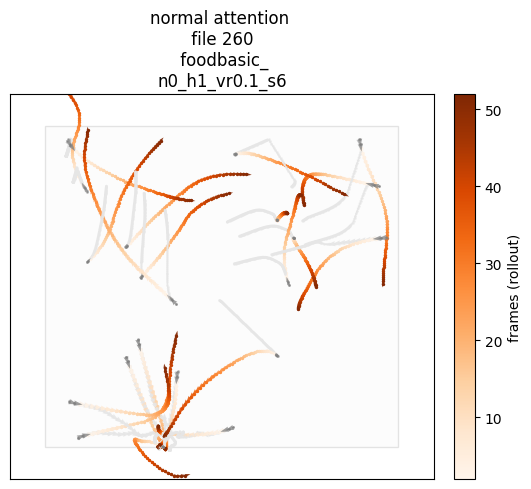

In [11]:
%matplotlib inline

model = 0
actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results[model],
                    file_id = file_id, epoch_num = 0)


ax = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                ending_frame = ending_frame)

ax.set_title(f'{"ablated" if ablation else "normal"} attention \n file {file_id} \n {model_names[model]}')
if save_flag:
    plt.savefig(f"rollout_file{file_id}_{model_names[model]}_{rollout_num}.pdf", bbox_inches="tight")

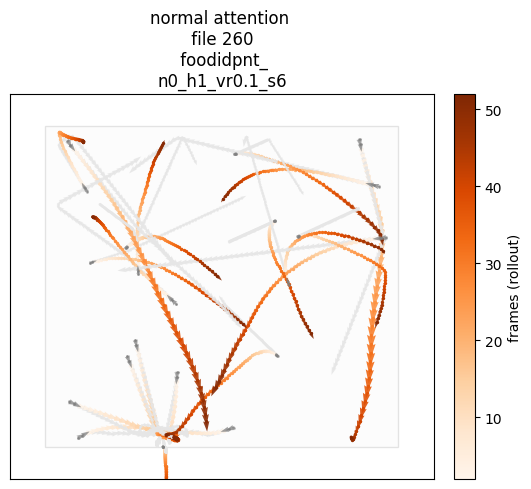

In [12]:
model = 1

actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results[model],
                    file_id = file_id, epoch_num = 0)


ax = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                            ending_frame = ending_frame)
ax.set_title(f'{"ablated" if ablation else "normal"} attention \n file {file_id} \n {model_names[model]}')
if save_flag:
    plt.savefig(f"rollout_file{file_id}_{model_names[model]}_ablate_{rollout_num}.pdf", bbox_inches="tight")

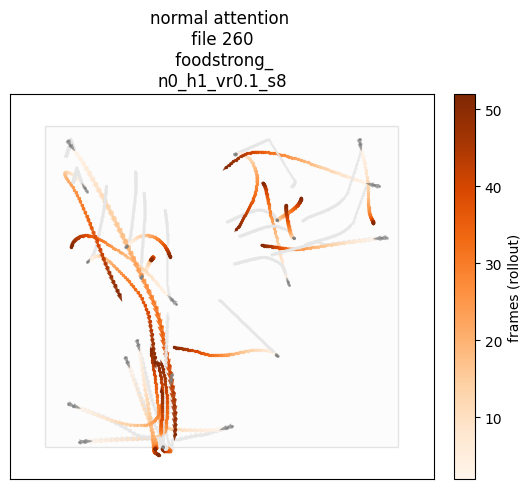

In [13]:
model = 2

actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results[model],
                    file_id = file_id, epoch_num = 0)


ax = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                            ending_frame = ending_frame)
ax.set_title(f'{"ablated" if ablation else "normal"} attention \n file {file_id} \n {model_names[model]}')
if save_flag:
    plt.savefig(f"rollout_file{file_id}_{model_names[model]}_ablate_{rollout_num}.pdf", bbox_inches="tight")